<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Исследование-задачи" data-toc-modified-id="Исследование-задачи-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследование задачи</a></span></li><li><span><a href="#Борьба-с-дисбалансом" data-toc-modified-id="Борьба-с-дисбалансом-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Борьба с дисбалансом</a></span></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование модели</a></span></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Общий вывод</a></span></li><li><span><a href="#Чек-лист-готовности-проекта" data-toc-modified-id="Чек-лист-готовности-проекта-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист готовности проекта</a></span></li></ul></div>

# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Нам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Нужно построить модель с предельно большим значением *F1*-меры. Условие заказчика: нужно довести метрику до 0.59. Проверить *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измерить *AUC-ROC*, сравнить её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import dump
from sklearn.model_selection import train_test_split, GridSearchCV 
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, precision_recall_curve, roc_curve, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression

## Подготовка данных

Для начала откроем файл и ознакомимся с общей информацией.

In [6]:
df = pd.read_csv('datasets/Churn.csv')

In [7]:
display(df.head(10));
df.info()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
5,6,15574012,Chu,645,Spain,Male,44,8.0,113755.78,2,1,0,149756.71,1
6,7,15592531,Bartlett,822,France,Male,50,7.0,0.00,2,1,1,10062.80,0
7,8,15656148,Obinna,376,Germany,Female,29,4.0,115046.74,4,1,0,119346.88,1
8,9,15792365,He,501,France,Male,44,4.0,142051.07,2,0,1,74940.50,0
9,10,15592389,H?,684,France,Male,27,2.0,134603.88,1,1,1,71725.73,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


Мы будем иметь дело с 10000 клиентами. Необходимые признаки присутствуют, целевой признак тоже, что облегчит нам работу.

Для удобства работы приведем названия столбцов к нижнему регистру.

In [8]:
df.columns = df.columns.str.lower()

Для начала посмотрим какую часть от общего объема данных составляют пропуски в столбце `Tenure(сколько лет человек является клиентом банка)`. Если менее 10% - целесообразно будет их удалить.

In [9]:
df['tenure'].isna().sum() / len(df)

0.0909

In [10]:
df = df.dropna().reset_index(drop=True)
df.shape

(9091, 14)

Фамилии клиентов, их ID и номер строки никак не влияют на целевой признак, можно удалить данные столбцы для упращения прямого кодирования.

In [11]:
df = df.drop(['customerid', 'rownumber', 'surname'], axis=1)
df.head(10)

,creditscore,geography,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited
0,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
5,645,Spain,Male,44,8.0,113755.78,2,1,0,149756.71,1
6,822,France,Male,50,7.0,0.00,2,1,1,10062.80,0
7,376,Germany,Female,29,4.0,115046.74,4,1,0,119346.88,1
8,501,France,Male,44,4.0,142051.07,2,0,1,74940.50,0
9,684,France,Male,27,2.0,134603.88,1,1,1,71725.73,0


Далее воспользуемся техникой прямого кодирования `One-Hot Encoding` для создания фиктивных переменных и переноса всех данных таблицы в численный вид.

In [12]:
df_ohe = pd.get_dummies(df, drop_first=True)

In [13]:
pd.set_option('display.max_columns', None)
df_ohe.head(10)

,creditscore,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited,geography_Germany,geography_Spain,gender_Male
0,619,42,2.0,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1.0,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8.0,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1.0,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2.0,125510.82,1,1,1,79084.10,0,0,1,0
5,645,44,8.0,113755.78,2,1,0,149756.71,1,0,1,1
6,822,50,7.0,0.00,2,1,1,10062.80,0,0,0,1
7,376,29,4.0,115046.74,4,1,0,119346.88,1,1,0,0
8,501,44,4.0,142051.07,2,0,1,74940.50,0,0,0,1
9,684,27,2.0,134603.88,1,1,1,71725.73,0,0,0,1


Нужно разбить данные на 3 выборки
- обучающая выборка
- валидационная выборка
- тестовая выборка

In [14]:
features = df_ohe.drop(['exited'], axis=1)
target = df_ohe['exited']

df_train, df_valid_and_test = train_test_split(df_ohe, test_size=0.4, random_state=12345)
df_valid, df_test = train_test_split(df_valid_and_test, test_size=0.50, random_state=12345)

features_train = df_train.drop(['exited'], axis=1)
target_train = df_train['exited']

features_valid = df_valid.drop(['exited'], axis=1)
target_valid = df_valid['exited']

features_test = df_test.drop(['exited'], axis=1)
target_test = df_test['exited']

print(features.shape)
print(target.shape)
print()
print('Размеры обучающей выборки:')
print(features_train.shape)
print(target_train.shape)
print()
print('Размеры валидационной выборки:')
print(features_valid.shape)
print(target_valid.shape)
print()
print('Размеры тестовой выборки:')
print(features_test.shape)
print(target_test.shape)

(9091, 11)
(9091,)

Размеры обучающей выборки:
(5454, 11)
(5454,)

Размеры валидационной выборки:
(1818, 11)
(1818,)

Размеры тестовой выборки:
(1819, 11)
(1819,)


Мы получили 3 выборки в пропорциях 60/20/20. Обучающая выборка забрала 60% данных, тестовая и валидационная поделили оставшиеся 40%.

## Исследование задачи

Для начала исследуем баланс классов.

In [15]:
display(df['exited'].loc[df['exited'] == 1].count() / len(df))
display(df['exited'].loc[df['exited'] == 0].count() / len(df))

0.2039379606203938

0.7960620393796062

20% от общего числа клиентов прекратили пользоваться банком. Дисбаланс классов на лицо в соотношении 20/80.

Обучим модель не взирая на дисбаланс классов.

In [21]:
model = DecisionTreeClassifier(random_state=12345)
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)

f1_score(target_valid, predicted_valid)

0.4920212765957447

In [22]:
model = RandomForestClassifier(random_state=12345)
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)

f1_score(target_valid, predicted_valid)

0.5874587458745875

Значение F1-меры 0.587 - ниже требуемого. Нужно поработать с дисбалансом.

## Борьба с дисбалансом

Постараемся подобрать наилучшие гиперпараметры для моделей, а также поработаем над балансом. Для начала укажем в гиперпараметрах моделей `class_weight = 'balanced'` и посмотрим на показатели. Примечание: совмещать up(down)sampling и class_weight нельзя, так как совмещения двух методов балансирования приводит к новому дисбалансу.

In [23]:
model = DecisionTreeClassifier()
parametrs = { 'max_depth': range (1, 11),
             'min_samples_leaf': range (1, 11),
             'min_samples_split': range (2, 10) }

# с помощью gridSearch находим лучшие гиперпараметры для модели, 
#обработка этих строк кода занимает много времени, поэтому после вывода делаю строки невидимыми

#grid = GridSearchCV(model, parametrs); 
#grid.fit(features_train, target_train);                                         

Получаем лучшие гиперпараметры для дерева решений.

In [24]:
#grid.best_params_ 

In [25]:
for depth in range(1, 16, 1):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth, class_weight = 'balanced')
    model.fit(features_train, target_train)
    predicted_valid = model.predict(features_valid)
    
print("F1:", f1_score(target_valid, predicted_valid))

F1: 0.4673629242819843


In [26]:
#подставляем наилучшие гиперпараметры

model = DecisionTreeClassifier(random_state=12345, max_depth=7, min_samples_leaf = 9, 
                               min_samples_split = 3, class_weight = 'balanced') 

model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)

f1_score(target_valid, predicted_valid)   

0.5560791705937794

Для дерева решений показатель Ф1-меры при подобранных гиперпараметрах и `class_weight = 'balanced`: 0.55

In [27]:
model = DecisionTreeClassifier(random_state=12345, max_depth=7, min_samples_leaf = 10, min_samples_split = 3)
model.fit(features_train, target_train)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

for threshold in np.arange(0, 0.9, 0.02):
    predicted_valid = probabilities_one_valid > threshold
    precision = precision_score(target_valid, predicted_valid)
    recall = recall_score(target_valid, predicted_valid)
    f1score = f1_score(target_valid, predicted_valid) 
    print("Порог = {:.2f} | Точность = {:.3f}, Полнота = {:.3f}".format(
        threshold, precision, recall))
    print(f1score)

Порог = 0.00 | Точность = 0.219, Полнота = 0.981
0.3578336557059962
Порог = 0.02 | Точность = 0.244, Полнота = 0.968
0.38933333333333336
Порог = 0.04 | Точность = 0.249, Полнота = 0.966
0.39629831246597713
Порог = 0.06 | Точность = 0.292, Полнота = 0.934
0.4447252053063803
Порог = 0.08 | Точность = 0.363, Полнота = 0.894
0.5160796324655437
Порог = 0.10 | Точность = 0.391, Полнота = 0.851
0.5363408521303258
Порог = 0.12 | Точность = 0.397, Полнота = 0.846
0.5406779661016949
Порог = 0.14 | Точность = 0.407, Полнота = 0.841
0.5489177489177489
Порог = 0.16 | Точность = 0.410, Полнота = 0.817
0.545615589016829
Порог = 0.18 | Точность = 0.441, Полнота = 0.798
0.5679245283018869
Порог = 0.20 | Точность = 0.446, Полнота = 0.793
0.5711556829035338
Порог = 0.22 | Точность = 0.446, Полнота = 0.793
0.5711556829035338
Порог = 0.24 | Точность = 0.547, Полнота = 0.676
0.6049822064056939
Порог = 0.26 | Точность = 0.547, Полнота = 0.676
0.6049822064056939
Порог = 0.28 | Точность = 0.620, Полнота = 0.63

При пороге в 0.32 для дерева решений достигается значение ф1-меры в 0.629

Далее попробуем случайный лес.

In [28]:
best_depth = 0
best_est = 0
best_result = 0
for depth in range(1, 16, 1):
    for est in range(10, 60, 10):   
        model = RandomForestClassifier(max_depth=depth, random_state=12345, n_estimators=est, class_weight = 'balanced')
        model.fit(features_train, target_train)
        result = model.score(features_valid, target_valid) 
        if result > best_result:        
            best_result = result   
            best_est = est
            best_depth = depth
        
print(f"Accuracy наилучшей модели на валидационной выборке: {best_result}, Количество деревьев: {best_est}, Максимальная глубина: {best_depth}")

Accuracy наилучшей модели на валидационной выборке: 0.8624862486248625, Количество деревьев: 30, Максимальная глубина: 13


Сейчас снова обратимся к инструменту GridSearchCV, закомментированы строки по тому же принципу, что при работе с моделью дерева решений (для случайного леса время обработки может занимать более 10 минут, поэтому после запуска ячейки можно смело идти пить кофе :) )

In [29]:
model = RandomForestClassifier()
parametrs = { 'max_depth': range (1, 13, 2),
             'n_estimators': range (10, 51, 10),
             'min_samples_leaf': range (1, 11),
             'min_samples_split': range (2, 10, 2) }
#grid = GridSearchCV(model, parametrs);
#grid.fit(features_train, target_train);

In [30]:
#grid.best_params_

In [32]:
model = RandomForestClassifier(max_depth=11, random_state=12345, min_samples_leaf = 3, min_samples_split = 4, n_estimators=50, class_weight = 'balanced')
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)

f1_score(target_valid, predicted_valid)   

0.6355382619974059

Для случайного леса показатель Ф1-меры при подобранных гиперпараметрах и `class_weight = 'balanced`: 0.635

Порог = 0.00 | Точность = 0.207, Полнота = 1.000
0.34350797266514804
Порог = 0.02 | Точность = 0.224, Полнота = 0.995
0.36585365853658536
Порог = 0.04 | Точность = 0.245, Полнота = 0.981
0.39215686274509803
Порог = 0.06 | Точность = 0.277, Полнота = 0.971
0.43058823529411766
Порог = 0.08 | Точность = 0.310, Полнота = 0.955
0.4675324675324676
Порог = 0.10 | Точность = 0.338, Полнота = 0.931
0.4964639321074964
Порог = 0.12 | Точность = 0.367, Полнота = 0.910
0.5232646834477498
Порог = 0.14 | Точность = 0.396, Полнота = 0.886
0.5475409836065575
Порог = 0.16 | Точность = 0.426, Полнота = 0.859
0.5694200351493849
Порог = 0.18 | Точность = 0.445, Полнота = 0.830
0.5796296296296296
Порог = 0.20 | Точность = 0.467, Полнота = 0.796
0.5888125613346418
Порог = 0.22 | Точность = 0.503, Полнота = 0.772
0.608786610878661
Порог = 0.24 | Точность = 0.540, Полнота = 0.751
0.62819089900111
Порог = 0.26 | Точность = 0.556, Полнота = 0.719
0.6273148148148148
Порог = 0.28 | Точность = 0.575, Полнота = 0.68

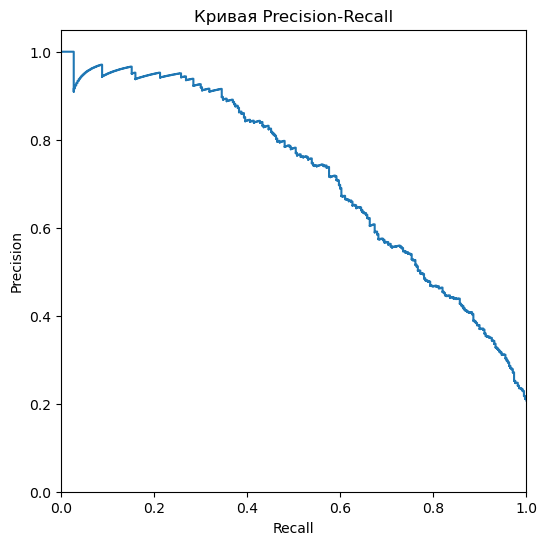

In [33]:
model = RandomForestClassifier(max_depth=11, random_state=12345, min_samples_leaf = 3, min_samples_split = 4, n_estimators=50)
model.fit(features_train, target_train)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

for threshold in np.arange(0, 0.8, 0.02):
    predicted_valid = probabilities_one_valid > threshold
    precision = precision_score(target_valid, predicted_valid)
    recall = recall_score(target_valid, predicted_valid)
    f1score = f1_score(target_valid, predicted_valid) 
    print("Порог = {:.2f} | Точность = {:.3f}, Полнота = {:.3f}".format(
        threshold, precision, recall))
    print(f1score)
    
precision, recall, thresholds = precision_recall_curve(target_valid, probabilities_valid[:, 1])

plt.figure(figsize=(6, 6))
plt.step(recall, precision, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Кривая Precision-Recall')
plt.show() 

При пороге в 0.36 для случайного леса достигается значение ф1-меры в 0.643

Cудя по всем показателям графиков и метрик, модель случайного леса должна нам подойти и выдать результат Ф1-меры выше 0.59.

## Тестирование модели

Протестируем нашу лучшую модель на тестировочной выборке.

In [34]:
#первый способ с использованием class_weight = 'balanced'

model = RandomForestClassifier(max_depth=11, random_state=12345, min_samples_leaf = 3, 
                               min_samples_split = 4, n_estimators=50, class_weight = 'balanced')
model.fit(features_train, target_train)
predicted_test = model.predict(features_test)

f1_score(target_test, predicted_test) 

0.6041958041958041

In [35]:
#второй способ с использованием порога 

#сначала указываем найденные гиперпараметры

model = RandomForestClassifier(random_state=12345, max_depth=11, min_samples_leaf=3, min_samples_split=4, n_estimators= 50)
model.fit(features_train, target_train)
probabilities_test = model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]

#далее указываем значение порога

threshold = 0.36
predicted_test = probabilities_one_test > threshold
f1score = f1_score(target_test, predicted_test) 
f1score

0.6149162861491629

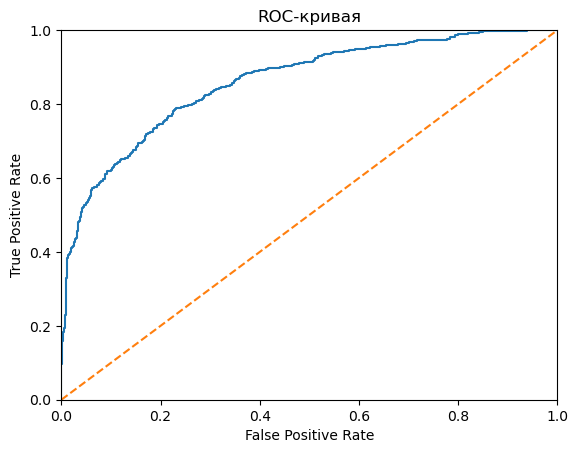

0.8591703734755507

In [36]:
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)

plt.figure()
plt.plot(fpr, tpr)

plt.plot([0, 1], [0, 1], linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('ROC-кривая')

plt.show()

auc_roc = roc_auc_score(target_test, probabilities_one_test)
auc_roc

Нам удалось достичь метрики Ф1-меры в 0.6149 с помощью модели случайного леса.

Метрика AUC-ROC лучше, чем у случайной модели.

## Общий вывод

**Мне была поставлена задача построить модель с предельно большим значением F1-меры (более 0.59).**

Первым этапом, после ознакомления с данными, была проведена их предобработка.
1. Из фрейма были удалены строки с пропусками в столбце `Tenure(сколько лет человек является клиентом банка)`. От первоначального объема в 10.000 клиентов банка осталось 9091.


2. Были удалены столбцы, которые никак не помогут исследованию и никак не влияют на целевой признак ('customerid', 'rownumber', 'surname')


3. Общая выборка была разбита на 3 части в пропорциях 3:1:1  
 - обучающая выборка
 - валидационная выборка
 - тестовая выборка

Далее было определено, что 20% от общего числа клиентов прекратили пользоваться банком. Дисбаланс классов на лицо в соотношении 20/80.


    В результате исследования задачи без обработки дизбаланса классов и тщательной настройки моделей, было получено значение Ф1-меры 0.5874587458745875. Этот результат меньше требуемого, поэтому его требуется улучшать. 
    
Мной было принято решение начать борьбу с дисбалансом начиная с использования гиперпараметра модели `class_weight = 'balanced'`, а также найти наилучшие остальные гиперпараметры.


Вторым способом улучшить баланс и показатели Ф1-меры стало изменение порога классификации.


**Лучшей моделью оказался случайный лес, который на валидационной выборке выдавал значение Ф1-меры в 0.64.**


После того, как были подобраны гиперпараметры на валидации  - модель была протестирована на тестовой выборке. 
 - Значение Ф1-меры достигло 0.6149, **поставленная заказчиком задача выполнена**
 - Показатель эффективности модели (AUC-ROC) - 0.859 